<h1>생성 모델</h1>

In [1]:
# 라이브러리
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# MNIST 데이터, 1D 데이터로 Flatten하여 사용
mnist = tf.keras.datasets.mnist
(xtrain,ytrain), (xtest,ytest) = mnist.load_data()
xtrain, xtest = xtrain/255.0, xtest/255.0
xtrain = xtrain.reshape( (len(xtrain), 28*28) )
xtest = xtest.reshape( (len(xtest), 28*28) )
print( xtrain.shape, xtest.shape )

11490434/11490434 [==============================] - 1s 0us/step
(60000, 784) (10000, 784)


# VAE

In [3]:
# 네트워크 파라메터
input_size = 784
n_hidden = 256
latent_size = 2

Encoder

In [4]:
# 샘플링 함수: N(m,v)에서 난수를 추출
def sampling(args):
    m, v = args  # v는 log(var)
    epsilon = tf.random.normal( shape=tf.shape(m) ) # 정규 분포에서 난수 추출
    return m + tf.math.exp(0.5 * v) * epsilon   # N(0,1) -> N(m,v)

In [5]:
input = tf.keras.Input(shape=(input_size,), name='input')
hidden = tf.keras.layers.Dense(
    n_hidden, activation='relu', name='hidden')(input)
z_mean = tf.keras.layers.Dense(latent_size, name='z_mean')(hidden)
z_var = tf.keras.layers.Dense(latent_size, name='z_var')(hidden)
z = tf.keras.layers.Lambda(sampling, name='z_sampling')([z_mean, z_var])
encoder = tf.keras.Model( input, [z_mean, z_var, z] )

In [6]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 784)]                0         []                            
                                                                                                  
 hidden (Dense)              (None, 256)                  200960    ['input[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 2)                    514       ['hidden[0][0]']              
                                                                                                  
 z_var (Dense)               (None, 2)                    514       ['hidden[0][0]']              
                                                                                              

In [7]:
tf.keras.utils.plot_model(encoder, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Decoder

In [8]:
# 디코더 입력은 latent 변수로부터
input = tf.keras.Input(shape=(latent_size,), name='input')
hidden = tf.keras.layers.Dense(
    n_hidden, activation='relu', name='hidden')(input)
# 출력은 인코더 입력과 같도록 학습하기 때문에 input_size가 사용
output = tf.keras.layers.Dense(
    input_size, activation='sigmoid',name='output')(hidden)
decoder = tf.keras.Model( input, output, name='decoder' )

In [9]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 hidden (Dense)              (None, 256)               768       
                                                                 
 output (Dense)              (None, 784)               201488    
                                                                 
Total params: 202256 (790.06 KB)
Trainable params: 202256 (790.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
tf.keras.utils.plot_model(decoder, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


VAE

In [11]:
input = tf.keras.Input(shape=(input_size,), name='input')
z = encoder(input)[2]  # [0]: z_mean, [1]: z_var, [2]: z
output = decoder(z)
model = tf.keras.Model(input, output, name='vae')

In [12]:
model.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 model (Functional)          [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404244 (1.54 MB)
Trainable params: 404244 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


훈련

In [14]:
# 훈련 파라메터
r_loss_factor = 1000

In [15]:
# 손실함수 정의
def vae_loss(x, recon_x):
  # 재구성을 위한 복원 손실
  m, v, z = encoder(x)
  recon_x = decoder(z)
  r_loss = tf.keras.losses.mse(x,recon_x)
  # 원하는 분포로 맞추기 위한 KL Divergence 손실
  # m = 0, v = log(var) = 0이 되면 최소
  kl_loss = 0.5*tf.reduce_sum(tf.square(m) + tf.exp(v) - v - 1, axis=1)
  return tf.reduce_mean(r_loss*r_loss_factor + kl_loss)

In [16]:
model.compile(optimizer='adam',loss=vae_loss)

In [17]:
model.fit( xtrain, xtrain, epochs=20 )

Epoch 1/20
1875/1875 [==============================] - 2s 1ms/step - loss: 59.9750
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 53.3308
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 51.9029
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 51.0147
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 50.3819
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 49.8612
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 49.4703
Epoch 8/20
1875/1875 [==============================] - 2s 1ms/step - loss: 49.1552
Epoch 9/20
1875/1875 [==============================] - 2s 1ms/step - loss: 48.8582
Epoch 10/20
1875/1875 [==============================] - 2s 1ms/step - loss: 48.6004
Epoch 11/20
1875/1875 [==============================] - 2s 1ms/step - loss: 48.4017
Epoch 12/20
1875/1875 [==============================] - 2s 1ms/step - los

복원 테스트

In [18]:
r_xtest = model.predict(xtest)
print("mse: ",np.array(tf.keras.losses.mse(xtest,r_xtest)).mean())

313/313 [==============================] - 0s 540us/step
mse:  0.042566054


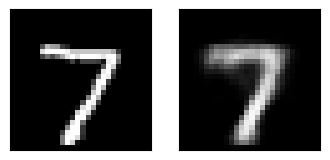

In [19]:
plt.figure(figsize=(4, 8))
ax = plt.subplot(1, 2, 1)
plt.imshow(xtest[0].reshape(28,28), vmin=0, vmax=1, cmap="gray")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.imshow(r_xtest[0].reshape(28,28), vmin=0, vmax=1, cmap="gray")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

생성 테스트

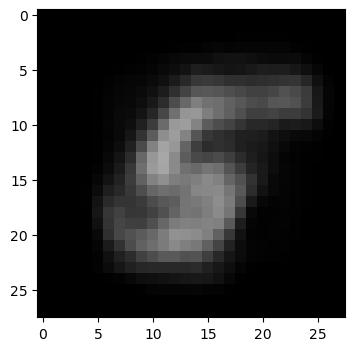

In [20]:
# N(0,1)을 따르는 2차원 잠재변수를 입력으로
new = decoder(np.array([[0,0]]))
plt.figure(figsize=(4, 4))
plt.imshow(np.array(new[0]).reshape(28,28), vmin=0, vmax=1, cmap="gray")

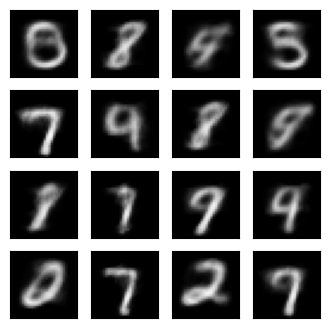

In [21]:
plt.figure(figsize=(4, 4))
for i in range(16):
  new = decoder( np.random.randn(2).reshape((1,2)) )
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(np.array(new[0]).reshape(28,28), vmin=0, vmax=1, cmap="gray")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

# 연습문제

1. 위의 코드에서 네트워크/훈련 파라메터를 적절히 조절하여 더 나은 결과를 얻을 수 있는지 확인하시오.<br>
(1) n_hidden을 512로 하였을 때 전체 VAE 모델의 파라메터 수는 몇 개인가?<br>
(2) 이 경우 평가 데이터의 MSE는 얼마인가?<br>
(3) 생성이 얼마나 잘 되는지를 평가할 수 있는 방안을 고안하여 간략히 서술하시오.<br>

In [22]:
# 네트워크 파라메터
input_size = 784
n_hidden = 512
latent_size = 2

In [23]:
# 샘플링 함수: N(m,v)에서 난수를 추출
def sampling(args):
    m, v = args  # v는 log(var)
    epsilon = tf.random.normal( shape=tf.shape(m) ) # 정규 분포에서 난수 추출
    return m + tf.math.exp(0.5 * v) * epsilon   # N(0,1) -> N(m,v)

In [24]:
input = tf.keras.Input(shape=(input_size,), name='input')
hidden = tf.keras.layers.Dense(
    n_hidden, activation='relu', name='hidden')(input)
z_mean = tf.keras.layers.Dense(latent_size, name='z_mean')(hidden)
z_var = tf.keras.layers.Dense(latent_size, name='z_var')(hidden)
z = tf.keras.layers.Lambda(sampling, name='z_sampling')([z_mean, z_var])
encoder = tf.keras.Model( input, [z_mean, z_var, z] )

In [25]:
encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 784)]                0         []                            
                                                                                                  
 hidden (Dense)              (None, 512)                  401920    ['input[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 2)                    1026      ['hidden[0][0]']              
                                                                                                  
 z_var (Dense)               (None, 2)                    1026      ['hidden[0][0]']              
                                                                                            

In [26]:
tf.keras.utils.plot_model(encoder, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
# 디코더 입력은 latent 변수로부터
input = tf.keras.Input(shape=(latent_size,), name='input')
hidden = tf.keras.layers.Dense(
    n_hidden, activation='relu', name='hidden')(input)
# 출력은 인코더 입력과 같도록 학습하기 때문에 input_size가 사용
output = tf.keras.layers.Dense(
    input_size, activation='sigmoid',name='output')(hidden)
decoder = tf.keras.Model( input, output, name='decoder' )

In [28]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 hidden (Dense)              (None, 512)               1536      
                                                                 
 output (Dense)              (None, 784)               402192    
                                                                 
Total params: 403728 (1.54 MB)
Trainable params: 403728 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
tf.keras.utils.plot_model(decoder, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


VAE

In [30]:
input = tf.keras.Input(shape=(input_size,), name='input')
z = encoder(input)[2]  # [0]: z_mean, [1]: z_var, [2]: z
output = decoder(z)
model = tf.keras.Model(input, output, name='vae')

In [32]:
# (1) 807700

model.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 model_1 (Functional)        [(None, 2),               403972    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               403728    
                                                                 
Total params: 807700 (3.08 MB)
Trainable params: 807700 (3.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


훈련

In [34]:
# 훈련 파라메터
r_loss_factor = 1000

In [35]:
# 손실함수 정의
def vae_loss(x, recon_x):
  # 재구성을 위한 복원 손실
  m, v, z = encoder(x)
  recon_x = decoder(z)
  r_loss = tf.keras.losses.mse(x,recon_x)
  # 원하는 분포로 맞추기 위한 KL Divergence 손실
  # m = 0, v = log(var) = 0이 되면 최소
  kl_loss = 0.5*tf.reduce_sum(tf.square(m) + tf.exp(v) - v - 1, axis=1)
  return tf.reduce_mean(r_loss*r_loss_factor + kl_loss)

In [36]:
model.compile(optimizer='adam',loss=vae_loss)

In [37]:
model.fit( xtrain, xtrain, epochs=20 )

Epoch 1/20
1875/1875 [==============================] - 3s 2ms/step - loss: 57.4883
Epoch 2/20
1875/1875 [==============================] - 3s 2ms/step - loss: 52.2375
Epoch 3/20
1875/1875 [==============================] - 3s 2ms/step - loss: 50.9766
Epoch 4/20
1875/1875 [==============================] - 3s 2ms/step - loss: 50.1904
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 49.5533
Epoch 6/20
1875/1875 [==============================] - 3s 2ms/step - loss: 49.0489
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 48.5945
Epoch 8/20
1875/1875 [==============================] - 3s 2ms/step - loss: 48.2295
Epoch 9/20
1875/1875 [==============================] - 3s 2ms/step - loss: 47.9047
Epoch 10/20
1875/1875 [==============================] - 3s 2ms/step - loss: 47.6089
Epoch 11/20
1875/1875 [==============================] - 3s 2ms/step - loss: 47.3475
Epoch 12/20
1875/1875 [==============================] - 3s 2ms/step - los

복원 테스트

In [38]:
# (2) 0.04142247
r_xtest = model.predict(xtest)
print("mse: ",np.array(tf.keras.losses.mse(xtest,r_xtest)).mean())

313/313 [==============================] - 0s 672us/step
mse:  0.04142247


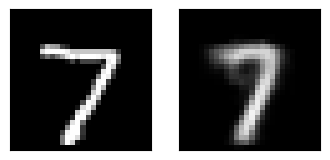

In [39]:
plt.figure(figsize=(4, 8))
ax = plt.subplot(1, 2, 1)
plt.imshow(xtest[0].reshape(28,28), vmin=0, vmax=1, cmap="gray")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.imshow(r_xtest[0].reshape(28,28), vmin=0, vmax=1, cmap="gray")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

생성 테스트

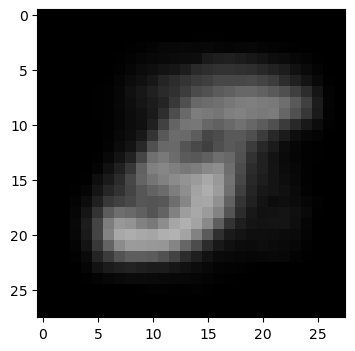

In [40]:
# N(0,1)을 따르는 2차원 잠재변수를 입력으로
new = decoder(np.array([[0,0]]))
plt.figure(figsize=(4, 4))
plt.imshow(np.array(new[0]).reshape(28,28), vmin=0, vmax=1, cmap="gray")

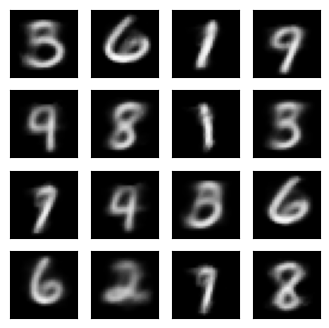

In [41]:
plt.figure(figsize=(4, 4))
for i in range(16):
  new = decoder( np.random.randn(2).reshape((1,2)) )
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(np.array(new[0]).reshape(28,28), vmin=0, vmax=1, cmap="gray")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)